In [2]:
import re
import pymysql
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from html.parser import HTMLParser
from pprint import pprint
import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
conn = pymysql.connect(host='localhost',
                           port=3306,
                           user='root',
                           passwd='',
                           db='rhs_wp')
cur = conn.cursor()
cur.execute("select rhs_posts.post_content as Publicação, DATE_FORMAT(rhs_posts.post_date, '%Y') as Ano,DATE_FORMAT(rhs_posts.post_date, '%m') as Mês,DATE_FORMAT(rhs_posts.post_date, '%d') as Dia,rhs_users.user_nicename as Autor from rhs_posts left join rhs_users on rhs_posts.post_author = rhs_users.ID where rhs_posts.post_type = 'post'") 

15285

In [5]:
# armazena o nome de cada uma das colunas do banco de dados
row_headers=[x[0] for x in cur.description]

# cria uma lista com os dados do banco
rhs_data = []
for row in cur:
    rhs_data.append(dict(zip(row_headers,row)))
    
# transforma a list em um dataframe
df = pd.DataFrame(rhs_data)
dflist = df['Publicação'].tolist()

In [6]:
# usa o beautifulsoup para limpar todo o html das postagens
def cleanMe(html):
    soup = BeautifulSoup(html, "lxml") # cria um novo objeto do bs4 para o item html
    for script in soup(["script", "style"]): # remove todos scripts e css
        script.extract()
    # get text
    text = soup.get_text()
    # quebrar em linhas e remove espaço à esquerda e à direita em cada
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # remove linhas em branco
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text


# Tratamento simples de texto, remove caracteres especiais e númericos
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"[\,\$\&\*\%\(\)\~\-\"\^\+\#\/|0-9]", " ")
    df[text_field] = df[text_field].str.replace(r"[\.\=\'\:\;\?\!\_\...]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"\[[^]]*\]", " ")
    df[text_field] = df[text_field].str.lower()
    return df

In [7]:
# remove caracteres ASCII do texto
df_ascii=[]
for item in dflist:
    parser = HTMLParser()
    df_ascii.append(parser.unescape(item))
    
df['Publicação'] = df_ascii

In [8]:
df_soup = []
for text in df.get('Publicação'):
       df_soup.append(cleanMe(text))
        
df['Publicação'] = df_soup

C:\Users\eduar\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.change.org/pt-BR/peti%C3%A7%C3%B5es/presidente-dilma-n%C3%A3o-acabe-com-o-sus-atosus?utm_campaign=share_button_action_box&utm_medium=facebook&utm_source=share_petition" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\eduar\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://youtu.be/YTYiTSnFWME" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [9]:
df = standardize_text(df, 'Publicação')

In [10]:
# remove stopwords
# Por serem textos mais completos usar um arquivo próprio para stopwords
pathStopwords = "C:\\Users\\eduar\\Desktop\stopwords.txt"

# Read in and split the stopwords file.
with open(pathStopwords, 'r') as f:
    stop_words = f.read().split("\n")

# transforma as postagens que estão no dataframe em lista para retirar as stopwords
dflist = df['Publicação'].tolist()

my_new_list = [[word for word in text.split() if word not in stop_words] for text in dflist]
my_new_list = [ ' '.join(l) for l in my_new_list]


In [11]:
df['Publicação'] = my_new_list

In [12]:
my_new_list2 = [x for x in my_new_list if x != '']

In [ ]:
my_new_list2

In [13]:
# Tokenize das palavras
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(my_new_list2))

print(data_words[:1])

[['os', 'beneficios', 'da', 'recreacao', 'na', 'recuperacao', 'hospitalar', 'resumo', 'estudos', 'cientificos', 'sobre', 'correlacao', 'do', 'bom', 'humor', 'alegria', 'dos', 'sentimentos', 'positivos', 'na', 'prevencao', 'de', 'doencas', 'no', 'auxilio', 'recuperacao', 'de', 'diversas', 'patologias', 'fica', 'cada', 'vez', 'mais', 'evidente', 'pois', 'alem', 'do', 'aspecto', 'fisiologico', 'riso', 'faz', 'bem', 'ao', 'psicologico', 'social', 'que', 'tristeza', 'falta', 'de', 'pensamento', 'positivo', 'nao', 'fazem', 'bem', 'saude', 'todo', 'mundo', 'concorda', 'fazer', 'da', 'alegria', 'uma', 'companheira', 'diaria', 'mesmo', 'nas', 'dificuldades', 'faz', 'maravilhas', 'no', 'organismo', 'riso', 'alegria', 'estimulam', 'producao', 'de', 'endorfinas', 'regulam', 'os', 'niveis', 'hormonais', 'velho', 'ditado', 'rir', 'melhor', 'remedio', 'comeca', 'ganhar', 'um', 'lugar', 'de', 'destaque', 'no', 'mundo', 'cientifico', 'palavras', 'chave', 'riso', 'esperanca', 'sociedade', 'abstract', 's

In [14]:
# Construir modelos de bigrams e trigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\eduar\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['os', 'beneficios', 'da', 'recreacao', 'na', 'recuperacao', 'hospitalar', 'resumo', 'estudos_cientificos', 'sobre', 'correlacao', 'do', 'bom_humor', 'alegria', 'dos', 'sentimentos', 'positivos', 'na', 'prevencao', 'de', 'doencas', 'no', 'auxilio', 'recuperacao', 'de', 'diversas', 'patologias', 'fica', 'cada', 'vez', 'mais', 'evidente', 'pois', 'alem', 'do', 'aspecto', 'fisiologico', 'riso', 'faz', 'bem', 'ao', 'psicologico', 'social', 'que', 'tristeza', 'falta', 'de', 'pensamento', 'positivo', 'nao', 'fazem', 'bem', 'saude', 'todo', 'mundo', 'concorda', 'fazer', 'da', 'alegria', 'uma', 'companheira', 'diaria', 'mesmo', 'nas', 'dificuldades', 'faz', 'maravilhas', 'no', 'organismo', 'riso', 'alegria', 'estimulam', 'producao', 'de', 'endorfinas', 'regulam', 'os', 'niveis', 'hormonais', 'velho', 'ditado', 'rir', 'melhor', 'remedio', 'comeca', 'ganhar', 'um', 'lugar', 'de', 'destaque', 'no', 'mundo', 'cientifico', 'palavras_chave', 'riso', 'esperanca', 'sociedade', 'abstract', 'scientific'

In [15]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
    
# Lematização usando spacy
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
#import spacy
# Formar Bigrams
data_words_bigrams = make_bigrams(data_words)

# Inicia spacy 'pt' , mantendo apenas o componente de tagger (para eficiencia)
# python3 -m spacy download pt
nlp = spacy.load('pt', disable=['parser', 'ner'])

# Faz lematização mantendo apenas noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['recuperacao', 'hospitalar', 'resumir', 'estudo', 'cientificos', 'correlacao', 'bom_humor', 'alegria', 'sentimento', 'positivo', 'prevencao', 'doencas', 'auxiliar', 'recuperacao', 'patologia', 'ficar', 'cada', 'mais', 'evidente', 'alar', 'aspecto', 'fisiologico', 'riso', 'fazer', 'bem', 'psicologico', 'social', 'tristeza', 'falto', 'pensamento', 'positivar', 'nao', 'fazer', 'bem', 'saude', 'mundo', 'concordar', 'fazer', 'da', 'alegria', 'companheiro', 'diaria', 'mesmo', 'dificuldade', 'fazer', 'maravilhar', 'organismo', 'riso', 'alegria', 'estimular', 'producao', 'endorfinas', 'regular', 'hormonal', 'velho', 'ditar', 'rir', 'melhor', 'remedio', 'comeca', 'ganhar', 'lugar', 'destacar', 'mundo', 'cientifico', 'riso', 'esperanca', 'abstract', 'scientific', 'studies', 'good', 'mood', 'positivar', 'feelings', 'prevention', 'illnesses', 'recovery', 'diverse', 'pathologies', 'each', 'morar', 'evident', 'time', 'beyond', 'physiological', 'aspect', 'makes', 'psychological', 'and_the', 'positi

In [17]:
# Criar dicionário
id2word = corpora.Dictionary(data_lemmatized)

# Criar Corpus
texts = data_lemmatized

# TDF
corpus = [id2word.doc2bow(text) for text in texts]

# Verificar
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 8), (22, 1), (23, 6), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 4), (32, 3), (33, 1), (34, 1), (35, 2), (36, 1), (37, 3), (38, 2), (39, 1), (40, 1), (41, 1), (42, 5), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 5), (51, 3), (52, 1), (53, 2), (54, 2), (55, 2), (56, 1), (57, 1), (58, 2), (59, 1), (60, 2), (61, 10), (62, 1), (63, 1), (64, 1), (65, 9), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 5), (75, 3), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 9), (83, 1), (84, 3), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [18]:
id2word[0]

'abandonar'

In [19]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abandonar', 1),
  ('abordagem', 1),
  ('abr', 1),
  ('abstract', 1),
  ('acabar', 1),
  ('aceitacao', 3),
  ('acelerar', 1),
  ('acessivel', 2),
  ('acesso', 1),
  ('acoes', 1),
  ('acompanhar', 2),
  ('adrenalina', 1),
  ('afetividade', 1),
  ('afirmar', 2),
  ('afortunadamente', 1),
  ('agir', 1),
  ('agora', 1),
  ('agradavel', 1),
  ('agressivo', 1),
  ('ainda', 2),
  ('ajustamento', 1),
  ('alar', 8),
  ('alcancado', 1),
  ('alegria', 6),
  ('alem_disso', 1),
  ('ali', 1),
  ('alimentar', 1),
  ('alternativo', 1),
  ('alto', 1),
  ('alzheimer', 1),
  ('ambientar', 2),
  ('ambiente_hospitalar', 4),
  ('ambito', 3),
  ('amenizar', 1),
  ('americano', 1),
  ('amigar', 2),
  ('amor', 1),
  ('analisar', 3),
  ('and_the', 2),
  ('angina', 1),
  ('angustiar', 1),
  ('animar', 1),
  ('ano', 5),
  ('ansiedade', 2),
  ('antar', 1),
  ('apresentar', 1),
  ('area', 1),
  ('areas', 1),
  ('arritmia', 1),
  ('aspect', 1),
  ('aspecto', 5),
  ('assim', 3),
  ('assistencia', 1),
  ('assistir'

In [73]:
# Modelo LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           iterations=50,
                                           #chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [74]:
# Apresenta 10 palavras para cada tópico
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"nao" + 0.015*"pessoa" + 0.011*"mais" + 0.010*"ser" + 0.009*"vidar" + '
  '0.009*"formar" + 0.007*"trabalhar" + 0.007*"comer" + 0.006*"quando" + '
  '0.006*"doenca"'),
 (1,
  '0.011*"mundo" + 0.010*"das" + 0.009*"humano" + 0.007*"dos" + 0.005*"social" '
  '+ 0.005*"formar" + 0.005*"sociedade" + 0.005*"mais" + 0.004*"vidar" + '
  '0.004*"ciencia"'),
 (2,
  '0.068*"mental" + 0.021*"caps" + 0.021*"drogar" + 0.013*"loucura" + '
  '0.013*"atencao_psicossocial" + 0.012*"reforma_psiquiatrica" + '
  '0.011*"tratamento" + 0.010*"usuarios" + 0.009*"pessoa" + 0.009*"familiar"'),
 (3,
  '0.016*"saude" + 0.013*"mais" + 0.010*"tratamento" + 0.010*"medicar" + '
  '0.009*"ano" + 0.008*"medicamento" + 0.008*"pelar" + 0.008*"brasil" + '
  '0.008*"dos" + 0.008*"publicar"'),
 (4,
  '0.023*"nao" + 0.015*"fazer" + 0.013*"mais" + 0.011*"dizer" + 0.009*"quando" '
  '+ 0.009*"muito" + 0.007*"ficar" + 0.007*"dia" + 0.007*"pessoa" + '
  '0.006*"atar"'),
 (5,
  '0.064*"saude" + 0.016*"atencao" + 0.0

In [75]:
# Compute Perplexity 
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score (quanto maior melhor, diferente da perplexity)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.064852161356217

Coherence Score:  0.43892993750098636


In [76]:
# Visualizar os tópicos
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.140205 -0.170043       1        1  11.342126
17     0.120127  0.149867       2        1  10.161467
14     0.200014  0.015129       3        1   9.708368
4      0.078273  0.159148       4        1   9.652561
5      0.166380 -0.143001       5        1   9.097972
0      0.180252  0.122271       6        1   8.769500
15     0.041109 -0.190147       7        1   7.740946
6      0.065593 -0.152728       8        1   5.738585
9      0.076647 -0.128176       9        1   5.674539
3      0.066217 -0.012120      10        1   5.241210
18     0.070329  0.120323      11        1   2.679881
1      0.028668  0.156074      12        1   2.672000
7      0.005512 -0.007828      13        1   2.435220
12    -0.142194 -0.173906      14        1   1.952976
16    -0.048515  0.229060      15        1   1.832758
2     -0.077461  0.068241      16        1   1.706310
19    -0.160275 -0.065482      17        1   1.541533
13    -0.209562 -0.041597      18        1   0.898071
8     -0.298375 -0.043781      19        1   0.684433
10    -0.302944  0.108697      20        1   0.469543, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
686    Default  59023.000000           saude  59023.000000  30.0000  30.0000
373    Default  10999.000000     humanizacao  10999.000000  29.0000  29.0000
470    Default   4115.000000          mental   4115.000000  28.0000  28.0000
1283   Default   4355.000000          mulher   4355.000000  27.0000  27.0000
1502   Default  13541.000000             sus  13541.000000  26.0000  26.0000
539    Default  10883.000000          partir  10883.000000  25.0000  25.0000
492    Default  19859.000000             nao  19859.000000  24.0000  24.0000
368    Default   6144.000000        hospital   6144.000000  23.0000  23.0000
208    Default   9429.000000             dia   9429.000000  22.0000  22.0000
1409   Default   9263.000000        publicar   9263.000000  21.0000  21.0000
1768   Default   7879.000000        nacional   7879.000000  20.0000  20.0000
533    Default   5431.000000        paciente   5431.000000  19.0000  19.0000
272    Default   6258.000000         equipar   6258.000000  18.0000  18.0000
746    Default  16084.000000       trabalhar  16084.000000  17.0000  17.0000
1361   Default   9996.000000       politicar   9996.000000  16.0000  16.0000
2352   Default   3811.000000          cursar   3811.000000  15.0000  15.0000
706    Default   8800.000000          social   8800.000000  14.0000  14.0000
124    Default   2674.000000     comunicacao   2674.000000  13.0000  13.0000
2068   Default   4328.000000        usuarios   4328.000000  12.0000  12.0000
552    Default  10717.000000           pelar  10717.000000  11.0000  11.0000
750    Default   3691.000000      tratamento   3691.000000  10.0000  10.0000
56     Default   7213.000000         atencao   7213.000000   9.0000   9.0000
1990   Default   6327.000000          gestao   6327.000000   8.0000   8.0000
921    Default   6273.000000          brasil   6273.000000   7.0000   7.0000
600    Default   3658.000000       programar   3658.000000   6.0000   6.0000
218    Default   5305.000000         direito   5305.000000   5.0000   5.0000
1515   Default   4791.000000     trabalhador   4791.000000   4.0000   4.0000
769    Default  10329.000000           vidar  10329.000000   3.0000   3.0000
582    Default   6820.000000        praticar   6820.000000   2.0000   2.0000
57     Default   4656.000000     atendimento   4656.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
48639  Topic20     37.782673        patients     38.641754   5.3387  -5.8727
66659  Topic20     34.524364       marijuana     35.383446   5.3366  -5.9629
16648  Topic20     34.378864             del     35.237946   5.3365  -5.96

In [77]:
pyLDAvis.save_html(vis,'vis.html')

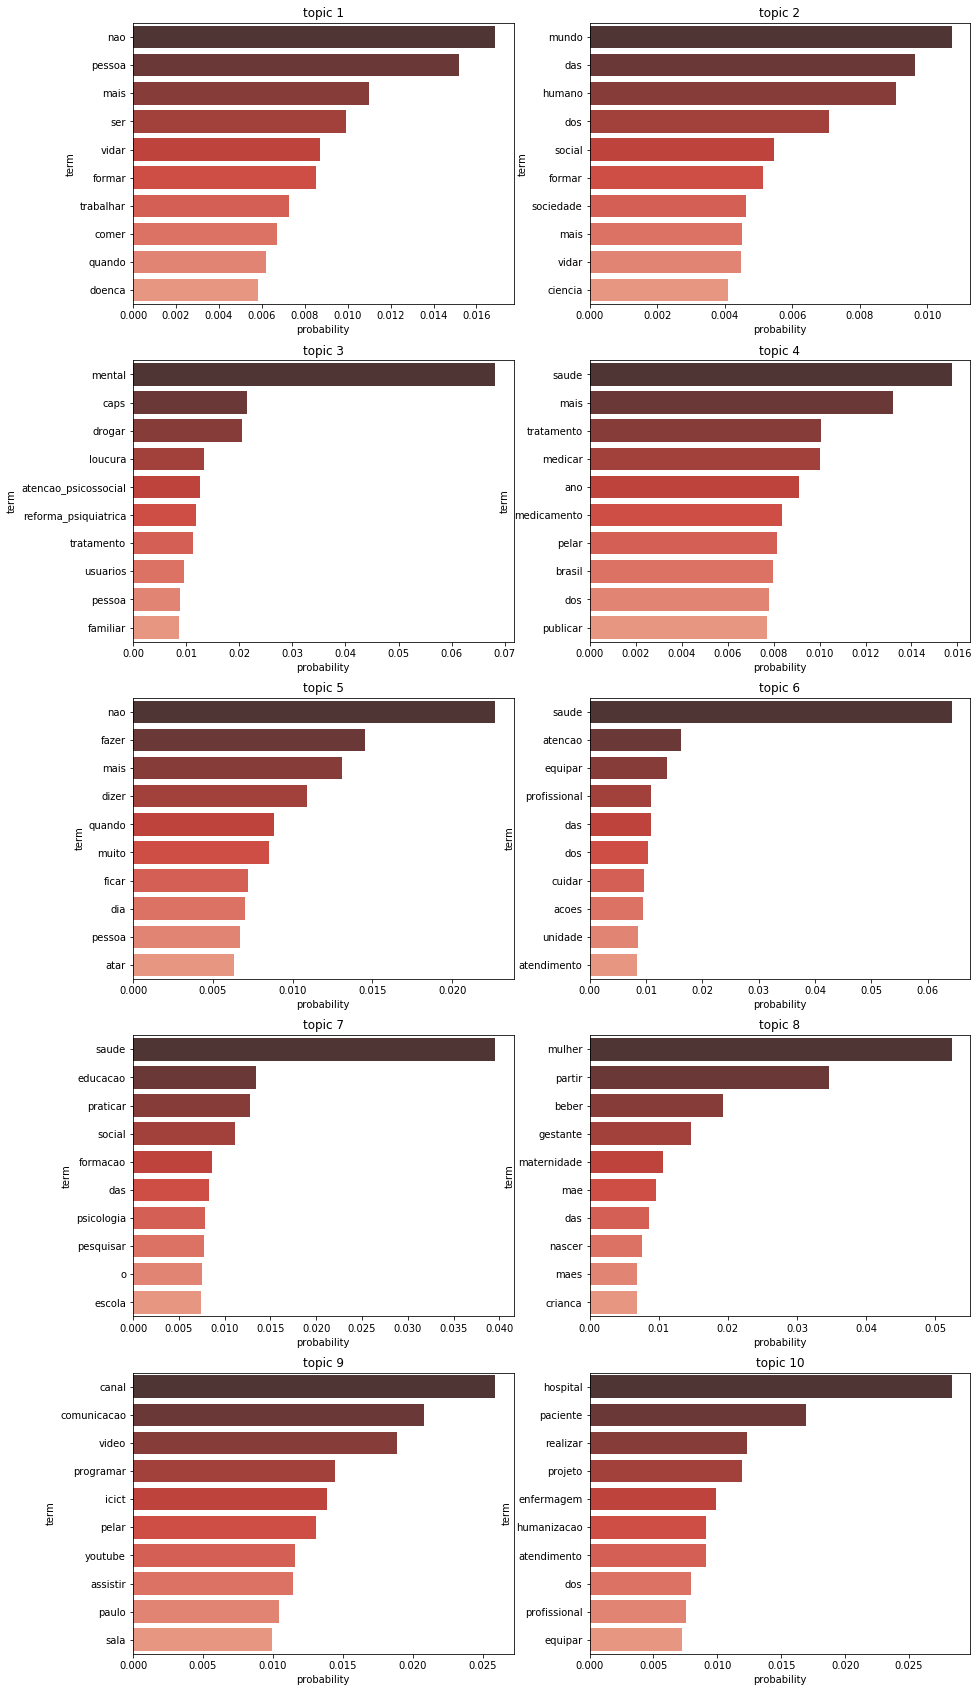

In [79]:
# probabilidade em que os termos aparecem nos 10 primeiros tópicos
lda_model.save('top10.model')
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
lda = gensim.models.LdaModel.load('./top10.model')
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()